In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import ollama  # Ollama (Phi-4) 연결

c:\Users\korea\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

# 전체 그래프에 적용할 폰트 설정
plt.rcParams["font.family"] = font_name

# 음수 기호(-)가 깨지지 않도록 설정
plt.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    message=".*Could not find the number of physical cores.*"
)


In [3]:
# CUDA 사용 가능 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ---------------------------
# 1. Train 데이터 로드 및 전처리
# ---------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv", encoding="utf-8-sig")

# 데이터프레임 기본 구조 확인
print("DataFrame Info:")
train_df.info()

print("\nDataFrame Head:")
print(train_df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               23422 non-null  object
 1   발생일시             23422 non-null  object
 2   사고인지 시간          23422 non-null  object
 3   날씨               23422 non-null  object
 4   기온               23422 non-null  object
 5   습도               23422 non-null  object
 6   공사종류             23422 non-null  object
 7   연면적              23422 non-null  object
 8   층 정보             23422 non-null  object
 9   인적사고             23390 non-null  object
 10  물적사고             21932 non-null  object
 11  공종               23411 non-null  object
 12  사고객체             22735 non-null  object
 13  작업프로세스           23359 non-null  object
 14  장소               23422 non-null  object
 15  부위               23422 non-null  object
 16  사고원인             23359 non-null  object
 17  재발방지대책 및 향후조치계획


결측치 개수:
ID                    0
발생일시                  0
사고인지 시간               0
날씨                    0
기온                    0
습도                    0
공사종류                  0
연면적                   0
층 정보                  0
인적사고                 32
물적사고               1490
공종                   11
사고객체                687
작업프로세스               63
장소                    0
부위                    0
사고원인                 63
재발방지대책 및 향후조치계획       0
dtype: int64
ID         0
발생일시       0
사고인지 시간    0
날씨         0
기온         0
습도         0
공사종류       0
연면적        0
층 정보       0
인적사고       0
물적사고       0
공종         0
사고객체       1
작업프로세스     0
장소         0
부위         0
사고원인       0
dtype: int64
텍스트 길이 평균: 60.441708008504605
텍스트 길이 분산: 1239.736668338425
텍스트 길이 중앙값 52.0


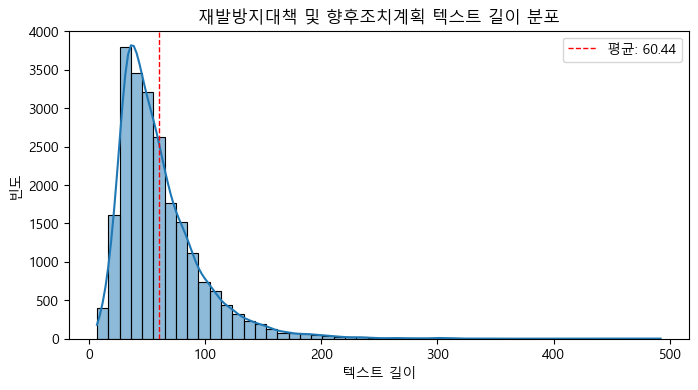

In [5]:
# 결측치 확인
print("\n결측치 개수:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# ✅ "물적사고"가 결측이면 "없음"으로 채우기
train_df["물적사고"] = train_df["물적사고"].fillna("없음")

# ✅ "인적사고", "공종", "사고객체", "작업프로세스", "사고원인" 결측치 제거
train_df = train_df.dropna(subset=["인적사고", "공종", "사고객체", "작업프로세스", "사고원인"])
test_df = test_df.fillna("")

# 타깃 컬럼(재발방지대책 및 향후조치계획)의 길이 계산
train_df["plan_length"] = train_df["재발방지대책 및 향후조치계획"].apply(len)

# 텍스트 길이의 평균과 분산 계산
mean_length = train_df["plan_length"].mean()
variance_length = train_df["plan_length"].var()
median_length = train_df["plan_length"].median()

print("텍스트 길이 평균:", mean_length)
print("텍스트 길이 분산:", variance_length)
print("텍스트 길이 중앙값", median_length)
# 텍스트 길이 분포 시각화
plt.figure(figsize=(8, 4))
sns.histplot(train_df["plan_length"], bins=50, kde=True)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'평균: {mean_length:.2f}')
plt.title("재발방지대책 및 향후조치계획 텍스트 길이 분포")
plt.xlabel("텍스트 길이")
plt.ylabel("빈도")
plt.legend()
plt.show()

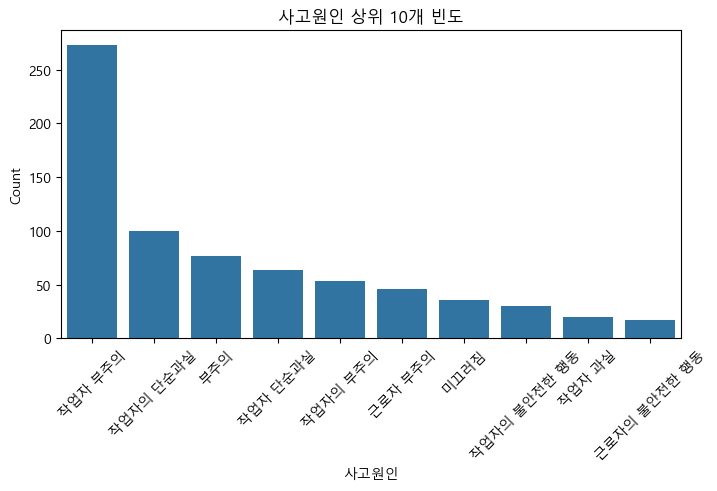

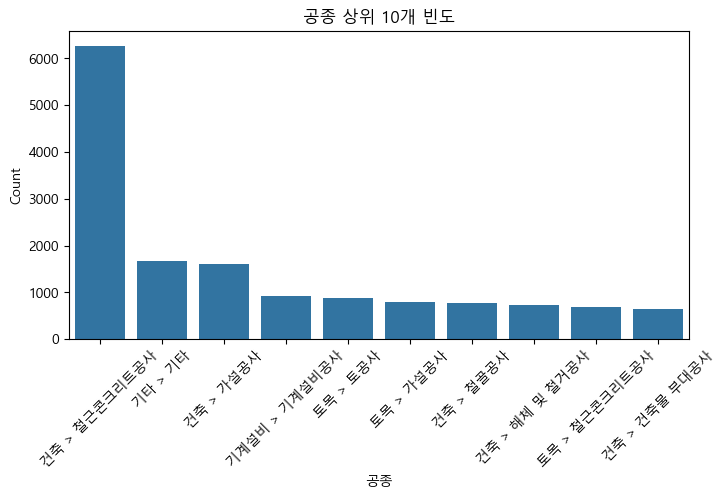

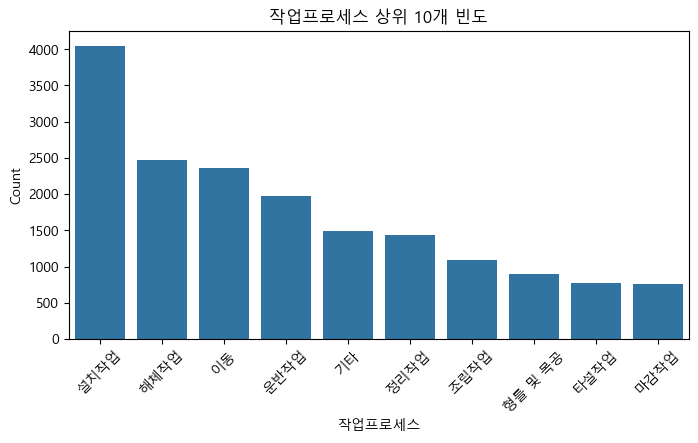

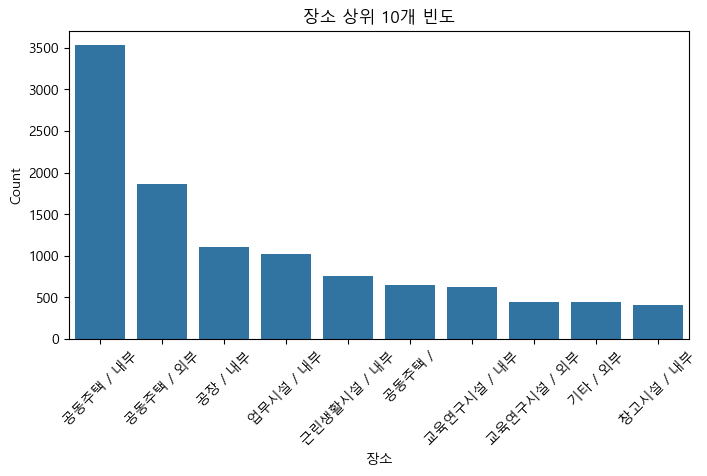

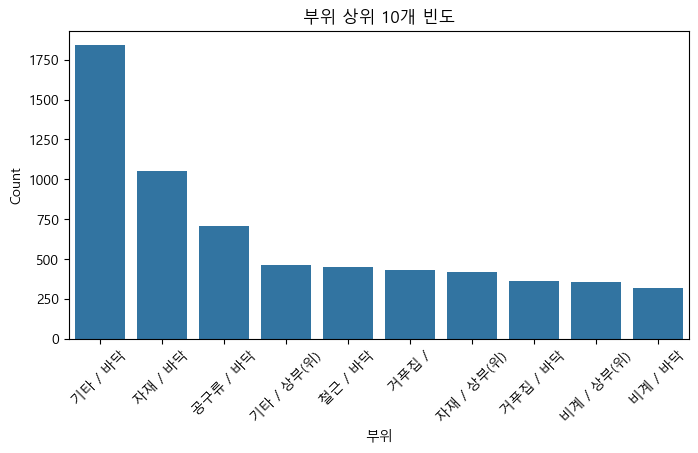

In [6]:
# 예: 사고원인, 공종, 작업프로세스, 장소, 부위 등 범주형 칼럼의 값 분포
categorical_cols = ["사고원인", "공종", "작업프로세스", "장소", "부위"]

for col in categorical_cols:
    value_counts = train_df[col].value_counts().head(10)  # 상위 10개만 예시
    plt.figure(figsize=(8, 4))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"{col} 상위 10개 빈도")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()


In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "cpu"
# SentenceTransformer 모델 로드
model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual", device=device)

# 필수 컬럼 확인
columns_needed = ["사고원인", "재발방지대책 및 향후조치계획"]
if not all(col in train_df.columns for col in columns_needed):
    raise ValueError(f"필수 컬럼 {columns_needed}이 데이터에 없습니다.")


In [8]:
# 벡터화 수행
vector_dict = {}  # 각 요소의 벡터 저장
for col in ["사고원인", "공종", "작업프로세스", "장소", "사고객체", "부위"]:
    vector_dict[col] = model.encode(train_df[col].tolist(), convert_to_numpy=True)

# 테스트 데이터 벡터화
test_vector_dict = {}
for col in ["사고원인", "공종", "작업프로세스", "장소", "사고객체", "부위"]:
    test_vector_dict[col] = model.encode(test_df[col].tolist(), convert_to_numpy=True)

# 이전 방식의 벡터화 수행행
# 학습 데이터: 사고객체와 사고원인 각각 벡터화
accident_object_vectors = model.encode(train_df["사고객체"].tolist(), convert_to_numpy=True)
accident_cause_vectors  = model.encode(train_df["사고원인"].tolist(), convert_to_numpy=True)

# 테스트 데이터: 사고객체와 사고원인 각각 벡터화
test_object_vectors = model.encode(test_df["사고객체"].tolist(), convert_to_numpy=True)
test_cause_vectors  = model.encode(test_df["사고원인"].tolist(), convert_to_numpy=True)

In [9]:
# 이전 가중치 계산방식

# 사용자 지정 가중치 (사용자가 변경 가능)
object_weight = 0.25  # 사고객체 가중치
cause_weight = 0.75  # 사고원인 가중치

# 유사도 행렬 계산
object_similarity_matrix = cosine_similarity(accident_object_vectors)  # 사고객체 유사도
cause_similarity_matrix = cosine_similarity(accident_cause_vectors)  # 사고원인 유사도

# 사용자 가중치를 반영한 최종 유사도 행렬
final_similarity_matrix = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)


# 유사한 사고 찾기 함수 (가중치 반영된 유사도 기준)
def find_similar_accidents(index, top_n=5):
    """
    주어진 사고의 인덱스를 기반으로 가장 유사한 사고를 찾음.
    동일 사고는 제외하고 top_n개를 반환.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # 자기 자신 제외, 상위 N개 선택
    return similar_indices, similarities[similar_indices]

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고객체: {train_df['사고객체'].iloc[example_index]}")
print(f"🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🏷 사고객체: {train_df['사고객체'].iloc[idx]}")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")



🔹 기준 사고 정보: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음. : 건축 > 철근콘크리트공사 : 설치작업 : 근린생활시설 / 내부 : 건설자재 > 철근 : 철근 / 고소
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.9246)
  🛑 사고 정보: 고소작업대 안전난간 설치 및 안전보호구 착용 미흡 : 건축 > 건축물 부대공사 : 청소작업 : 업무시설 / 외부 : 건설기계 > 고소작업차(고소작업대 등) : 고소작업차(고소작업대 등) / 바닥
  ⮩ 대응 대책: 협력사 대표, 임원 및 공사담당자 안전반성회 실시와 고소작업차 안전수칙 및 작업방법, 순서 등 안전규정 교육, 작업자 보호구 지급 및 착용방법 교육을 포함한 건축공사 종사자 사고예방 및 안전의식 고취를 위한 안전교육 주기적 실시 및 공사장 지도감독 강화.

🔸 2번째 유사한 사고 (유사도: 0.9203)
  🛑 사고 정보: 고소작업시 추락에 대한 대비 미흡 (안전고리 미체결) : 건축 > 철근콘크리트공사 : 기타 : 공동주택 / 내부 : 건설자재 > 철근 : 철근 / 바닥
  ⮩ 대응 대책: 고소작업 시 안전작업방법 교육, 안전벨트 착용 및 체결 교육, 작업구간 관리감독자 상주, 관리감독자 교육 실시, 안전고리 체결 및 사고 발생 시 보고 철저를 통한 재발 방지 대책.

🔸 3번째 유사한 사고 (유사도: 0.9178)
  🛑 사고 정보: 신호수 미배치로 인한 안전사고 : 건축 > 철근콘크리트공사 : 설치작업 : 근린생활시설 / 내부 : 건설기계 > 타워크레인 : 타워크레인 / 바닥
  ⮩ 대응 대책: 안전교육 실시와 신호수 배치에 대한 계획.

🔸 4번째 유사한 사고 (유사도: 0.9173)
  🛑 사고 정보: 형틀고정 작업 시 못이나 결속철물등이 튕겨져 나올 위험을 사전에 파악하여 보안경 일체형 안전모를 착용하였으나, 보안경을 사용하지 않음 : 건축 > 철근콘크리트공사 : 설치작업 :

In [11]:
# 사용자 지정 가중치 (요소별 중요도)
weights = {
    "사고원인": 0.45,
    "공종": 0.15,
    "작업프로세스": 0.1,
    "장소": 0.05,
    "사고객체": 0.15,
    "부위": 0.1
}

# 유사도 행렬 계산 및 가중치 반영
similarity_matrices = {}
for col in weights.keys():
    similarity_matrices[col] = cosine_similarity(vector_dict[col])

# 최종 유사도 행렬 계산
final_similarity_matrix = sum(weights[col] * similarity_matrices[col] for col in weights)

# 유사한 사고 찾기 함수
def find_similar_accidents(index, top_n=5):
    """
    주어진 사고의 인덱스를 기반으로 가장 유사한 사고를 찾음.
    동일 사고는 제외하고 top_n개를 반환.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # 자기 자신 제외, 상위 N개 선택
    return similar_indices, similarities[similar_indices]

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"🔹 기준 공종: {train_df['공종'].iloc[example_index]}")
print(f"🔹 기준 작업프로세스: {train_df['작업프로세스'].iloc[example_index]}")
print(f"🔹 기준 장소: {train_df['장소'].iloc[example_index]}")
print(f"🔹 기준 부위: {train_df['부위'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  🔹 공종: {train_df['공종'].iloc[idx]}")
    print(f"  🔹 작업프로세스: {train_df['작업프로세스'].iloc[idx]}")
    print(f"  🔹 장소: {train_df['장소'].iloc[idx]}")
    print(f"  🔹 부위: {train_df['부위'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")


🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
🔹 기준 공종: 건축 > 철근콘크리트공사
🔹 기준 작업프로세스: 설치작업
🔹 기준 장소: 근린생활시설 / 내부
🔹 기준 부위: 철근 / 고소
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.9011)
  🛑 사고원인: 안전시설물 미설치(외부 시스템비계 설치 작업 시 자재를 들고 이동 중 무릎이 벽체 철근에 찔림)
  🔹 공종: 건축 > 철근콘크리트공사
  🔹 작업프로세스: 설치작업
  🔹 장소: 공동주택 / 외부
  🔹 부위: 철근 / 앞
  ⮩ 대응 대책: 근로자 작업 및 이동을 위한 통행로 조성과 통행로 인근 철근에 철근캡 설치, 안전시설 설치에 대한 철저한 행정안내.

🔸 2번째 유사한 사고 (유사도: 0.8969)
  🛑 사고원인: 작업자가 안전화를 헐겁게 착용하여 철근 운반 중 데크에 걸려 안전화가 벚겨져 사고가 발생함.
  🔹 공종: 건축 > 철근콘크리트공사
  🔹 작업프로세스: 운반작업
  🔹 장소: 교육연구시설 / 내부
  🔹 부위: 철근 / 바닥
  ⮩ 대응 대책: 작업자 안전보호구 착용 적정 여부 교육 강화 및 실족 방지망 설치 예정.

🔸 3번째 유사한 사고 (유사도: 0.8940)
  🛑 사고원인: 보안경 미착용 상태로 거푸집 고정용 각재에 콘크리트 못을 박던 중 빗겨맞아 콘크리트 못 머리가 부러지며 사고발생
  🔹 공종: 건축 > 철근콘크리트공사
  🔹 작업프로세스: 설치작업
  🔹 장소: 업무시설 / 내부
  🔹 부위: 철근 / 고소
  ⮩ 대응 대책: 보안경 지급 및 착용을 통한 작업자의 안전 확보와 불안전 행동 교육 및 산재 처리에 대한 향후 조치 계획.

🔸 4번째 유사한 사고 (유사도: 0.8864)
  🛑 사고원인: 안전고리를 안전대 부착설비에 체결하지 않음.
  🔹 공종: 건축 > 철골공사
  🔹 작업프로세스: 설치작업
  🔹 장소: 공장 / 

In [12]:
# --- 4. 테스트 데이터와 학습 데이터 간의 유사도 계산 ---
# 각 테스트 샘플에 대해, 학습 데이터와의 유사도 계산
similarity_matrices_test = {}
for col in weights.keys():
    similarity_matrices_test[col] = cosine_similarity(test_vector_dict[col], vector_dict[col])  # (test vs train)

final_similarity_test = sum(weights[col] * similarity_matrices_test[col] for col in weights)

# --- 5. 유사 사고 찾기 ---
def find_similar_accidents_for_test(test_index, top_n=5):
    """
    주어진 테스트 샘플(test_index)의 사고원인, 공종, 작업프로세스, 장소, 부위를 고려하여,
    학습 데이터(train_df)에서 가장 유사한 사례 top_n개를 반환합니다.
    """
    similarities = final_similarity_test[test_index]
    similar_indices = np.argsort(-similarities)[:top_n]  # 내림차순 정렬하여 top_n 선택
    return similar_indices, similarities[similar_indices]

In [13]:
from langdetect import detect

def is_chinese(text):
    try:
        return detect(text) == "zh-cn"  # 중국어 감지
    except:
        return False  # 감지 실패 시 안전하게 처리
    
def generate_rag_response(top_k_cases, 기준_사고객체, 기준_사고원인, 기준_공종, 기준_작업프로세스, 기준_장소, 기준_부위):
    system_message = (
        "<|im_start|>system\n"
        "당신은 한국인 건설 사고 분석 전문가입니다.\n"
        "당신의 임무는 주어진 기준 사고에 대해 유사 사례들을 단계적으로 분석하고, 사고의 주요 위험요소와 원인을 파악하여, "
        "가장 효과적인 재발방지 대책과 향후 조치 계획을 도출하는 것입니다.\n"
        "유사 사례에는 사고객체, 사고원인, 공종, 작업프로세스, 장소, 부위, 대응 대책 정보가 포함되어 있으므로, "
        "각 항목을 비교·분석한 뒤, 기준 사고와 가장 유사한 패턴을 찾아 종합적으로 판단해야 합니다.\n"
        "사고의 구조와 맥락을 단계적으로 사고한 후 결론을 도출하세요.\n"
        "답변은 반드시 한국어로 작성해야 합니다.\n"
        "<|im_end|>"
    )

    user_message = (
        "<|im_start|>user\n"
        "[기준 사고]\n"
        f"- 사고객체: {기준_사고객체}\n"
        f"- 사고원인: {기준_사고원인}\n"
        f"- 공종: {기준_공종}\n"
        f"- 작업프로세스: {기준_작업프로세스}\n"
        f"- 장소: {기준_장소}\n"
        f"- 부위: {기준_부위}\n\n"
        "[유사 사례 - 기존 대응 대책들]:\n" +
        "\n".join([
            f"{i+1}. 사고객체: {case[0]}, 사고원인: {case[1]}, 공종: {case[2]}, 작업프로세스: {case[3]}, "
            f"장소: {case[4]}, 부위: {case[5]}, 대응 대책: {case[6]}"
            for i, case in enumerate(top_k_cases)
        ]) + "\n\n"
        "위의 유사 사례들을 참고하여, 기준 사고에 대한 최적의 재발방지대책 및 향후 조치 계획을 한 문장으로 작성하되, "
        "반드시 \"대응대책:\"으로 시작하는 한 문장으로 답변하세요.\n"
        "하나씩 차근차근 생각한 뒤, 최종 대응 대책을 도출하세요.\n"
        "<|im_end|>"
    )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    while True:
        response = ollama.chat(model="qwq", messages=messages)
        output = response["message"]["content"]
        
        if not is_chinese(output):  # 중국어가 없으면 반환
            return output
        
        print("❌ 중국어 감지됨. 다시 요청 중...")


In [14]:
def process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv"):
    """
    test_df의 각 샘플에 대해, 학습 데이터와의 최종 유사도를 기반으로 상위 유사 사례(top_n)를 추출한 후,
    generate_rag_response 함수를 호출하여 LLM(QWQ32B) 결과(최적의 재발방지대책 및 향후 조치 계획)를 생성합니다.
    결과는 콘솔에 출력하고, CSV 파일로 저장합니다.
    """
    results = []  # LLM 결과 저장 리스트

    # test_df의 각 샘플에 대해 처리
    for test_idx in tqdm(range(len(test_df)), desc="Processing test cases with LLM"):
        # 학습 데이터와의 최종 유사도에서 상위 top_n 사례 추출 (내림차순 정렬)
        similarities = final_similarity_test[test_idx]
        similar_indices = np.argsort(-similarities)[:top_n]
        
        # 상위 유사 사례에 대한 (사고객체, 사고원인, 공종, 작업프로세스, 장소, 부위, 대응 대책) 튜플 리스트 생성
        top_k_cases = [
            (
                train_df.iloc[i]["사고객체"],
                train_df.iloc[i]["사고원인"],
                train_df.iloc[i]["공종"],
                train_df.iloc[i]["작업프로세스"],
                train_df.iloc[i]["장소"],
                train_df.iloc[i]["부위"],
                train_df.iloc[i]["재발방지대책 및 향후조치계획"]
            )
            for i in similar_indices
        ]
        
        # 기준 사고 정보 추출
        기준_사고객체 = test_df.iloc[test_idx]["사고객체"]
        기준_사고원인 = test_df.iloc[test_idx]["사고원인"]
        기준_공종 = test_df.iloc[test_idx]["공종"]
        기준_작업프로세스 = test_df.iloc[test_idx]["작업프로세스"]
        기준_장소 = test_df.iloc[test_idx]["장소"]
        기준_부위 = test_df.iloc[test_idx]["부위"]
        
        # LLM 프롬프트에 따라 최적 대응 대책 생성
        rag_result = generate_rag_response(
            top_k_cases, 기준_사고객체, 기준_사고원인, 기준_공종, 기준_작업프로세스, 기준_장소, 기준_부위
        )
        results.append(rag_result)
        
        # # 콘솔 출력 (각 테스트 샘플 별 상세 정보)
        # print(f"--- Test Sample {test_idx} ---")
        # print(f"테스트 사고객체: {기준_사고객체}")
        # print(f"테스트 사고원인: {기준_사고원인}")
        # print(f"테스트 공종: {기준_공종}")
        # print(f"테스트 작업프로세스: {기준_작업프로세스}")
        # print(f"테스트 장소: {기준_장소}")
        # print(f"테스트 부위: {기준_부위}")
        # print("유사 학습 사례:")
        # for rank, i in enumerate(similar_indices, start=1):
        #     print(f"  {rank}. 사고객체: {train_df.iloc[i]['사고객체']}")
        #     print(f"     사고원인: {train_df.iloc[i]['사고원인']}")
        #     print(f"     공종: {train_df.iloc[i]['공종']}")
        #     print(f"     작업프로세스: {train_df.iloc[i]['작업프로세스']}")
        #     print(f"     장소: {train_df.iloc[i]['장소']}")
        #     print(f"     부위: {train_df.iloc[i]['부위']}")
        #     print(f"     대응 대책: {train_df.iloc[i]['재발방지대책 및 향후조치계획']}")
        #     print(f"     유사도: {similarities[i]:.4f}")
        # print("=== LLM 최종 결과 ===")
        # print(rag_result)
        # print("\n" + "-"*80 + "\n")
    
    # test_df에 LLM 결과를 추가하고 CSV 파일로 저장
    results_df = test_df.copy()
    results_df["LLM_결과"] = results
    results_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"LLM 결과가 '{output_csv}' 파일에 저장되었습니다.")
    
    return results_df

In [15]:
# 유사 사고 분석 및 LLM 결과 생성 실행
results_df = process_test_cases_with_llm(
    test_df=test_df,
    final_similarity_test=final_similarity_test,
    train_df=train_df,
    top_n=5,
    output_csv="llm_results_allfeatures.csv"
)


Processing test cases with LLM: 100%|██████████| 964/964 [5:57:13<00:00, 22.23s/it]  

LLM 결과가 'llm_results_allfeatures.csv' 파일에 저장되었습니다.


In [19]:
import re
# Step 0: 원본 데이터 길이 확인
print("Initial length of results_df:", len(results_df))

# 기본 답변 (threshold 미만의 경우 사용된 값)
default_answer = "작업전 안전교육 강화 및 작업장 위험요소 점검을 통한 재발 방지와 안전관리 교육 철저를 통한 향후 조치 계획."

def clean_response(text):
    """
    LLM으로 생성된 응답 텍스트에서 <think></think> 태그 내부 내용을 제거하고,
    '대응대책:' 이후의 문장만 추출합니다.
    그리고 문장 끝이 "한다." 또는 "입니다."로 끝나면 단순 마침표 '.'로 변경합니다.
    """
    # <think>...</think> 태그와 그 내부 내용 제거 (DOTALL 플래그 사용)
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    # '대응대책:' 이후의 문장을 추출 (존재하면)
    if "대응대책:" in cleaned:
        cleaned = cleaned.split("대응대책:")[-1].strip()
    # 중국어 문자 삭제 (Unicode 범위: \u4E00-\u9FFF)
    cleaned = re.sub(r'[\u4E00-\u9FFF]+', '', cleaned)
    return cleaned

# Step 1: LLM 응답 결과 정제 (default_answer가 아닌 항목에 대해)
cleaned_test_results = []
for res in results_df["LLM_결과"]:
    if res != default_answer and "대응대책:" in res:
        cleaned_test_results.append(clean_response(res))
    else:
        cleaned_test_results.append(res)

print("Length of cleaned_test_results:", len(cleaned_test_results))

# ---------------------------------------------------
# Step 7: 결과 벡터화 (제출을 위해 `jhgan/ko-sbert-sts` 사용)
# ---------------------------------------------------
# device 설정 (GPU 사용 시 "cuda", 없으면 "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
submission_embedding_model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

pred_embeddings = []
for i in tqdm(range(0, len(cleaned_test_results), 64), desc="Encoding Submission Results"):
    batch = cleaned_test_results[i : i + 64]
    batch_vectors = submission_embedding_model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
    pred_embeddings.extend(batch_vectors)

print("Length of pred_embeddings:", len(pred_embeddings))

# ---------------------------------------------------
# Step 8: 최종 제출 파일 생성
# ---------------------------------------------------
# test_df에 "ID" 컬럼이 존재한다고 가정 (없으면 해당 컬럼명을 수정)
submission = test_df[["ID"]].copy()
print("Length of submission (before adding responses):", len(submission))
print("Length of cleaned_test_results (should match submission length):", len(cleaned_test_results))

submission["재발방지대책 및 향후조치계획"] = cleaned_test_results

# 예측 벡터를 데이터프레임으로 변환 (각 열은 임베딩 차원)
submission_embedding_df = pd.DataFrame(pred_embeddings)
print("Shape of submission_embedding_df:", submission_embedding_df.shape)

# 두 데이터프레임 병합 (ID, 대응 대책, 벡터 컬럼)
submission = pd.concat([submission, submission_embedding_df], axis=1)
print("Final submission shape:", submission.shape)

# cleaned_test_results 리스트 내 NaN 체크
nan_indices = [i for i, x in enumerate(cleaned_test_results) if pd.isna(x)]
if nan_indices:
    print("cleaned_test_results에서 NaN이 발견된 인덱스:", nan_indices)
else:
    print("cleaned_test_results에 NaN이 없습니다.")

# submission DataFrame 내 NaN 체크
if submission.isnull().values.any():
    print("submission DataFrame에 NaN 값이 있습니다:")
    print(submission.isnull().sum())
else:
    print("submission DataFrame에 NaN 값이 없습니다.")

# ---------------------------------------------------
# Step 9: 결과 저장
# ---------------------------------------------------
submission_path = "QWQ_Allfeature_RAG_submission.csv"
print("Preview of submission DataFrame:")
print(submission.head())
submission.to_csv(submission_path, index=False, encoding="utf-8-sig")

Initial length of results_df: 964
Length of cleaned_test_results: 964


Encoding Submission Results: 100%|██████████| 16/16 [00:01<00:00, 11.58it/s]


Length of pred_embeddings: 964
Length of submission (before adding responses): 964
Length of cleaned_test_results (should match submission length): 964
Shape of submission_embedding_df: (964, 768)
Final submission shape: (964, 770)
cleaned_test_results에 NaN이 없습니다.
submission DataFrame에 NaN 값이 없습니다.
Preview of submission DataFrame:
         ID                                    재발방지대책 및 향후조치계획         0  \
0  TEST_000  콘크리트펌프카 아웃트리거 설치 시 지반 침하 방지를 위해 3단 보강 이상의 철저한 ... -0.478895   
1  TEST_001  안전교육 강화를 통해 핸드그라인더 사용 시 숫돌 정면만을 활용하는 올바른 절단 방법... -0.716559   
2  TEST_002  작업자 이동 중 실족사고 예방을 위해 안전교육 강화(계단 이용 시 주의사항, 전방주... -0.553916   
3  TEST_003  작업 발판 및 주변에 남은 벽돌 잔재를 즉시 제거하고, 말비계(720mm) 주변 안...  0.196034   
4  TEST_004  작업자들의 점심식사 이동 시 안전교육 강화와 현장 내 미끄러운 장소 등 위험요소를 ... -0.370688   

          1         2         3         4         5         6         7  ...  \
0 -0.567453  0.201043  1.109246 -0.531429  0.304901  0.953778 -0.542962  ...   
1  0.392996 -0.568496  0.272209 -0.419414  0.18979

In [20]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
'QWQ_Allfeature_RAG_submission.csv', 
'your-dacon-api-key', 
'236455', 
'mutoy', 
'QWQ_Allfeature_RAG_submission' )

{'isSubmitted': True, 'detail': 'Success'}
